In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import pandas as pd

import sklearn as sk
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
from sklearn.utils import class_weight

2022-11-28 16:44:34.087483: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Overall process will be
# Do the BERT transformations OUTSIDE of the model, and pass in as a matrix of dimensions:
# 20*768
# In addition, pass in list of features
# Concatenate dense layers inside the model

In [3]:
from transformers import BertTokenizer, TFBertModel
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

2022-11-28 16:44:37.076657: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-28 16:44:37.099645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-11-28 16:44:37.099664: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-11-28 16:44:37.100235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (o

In [4]:
# bring in the data
questions_data = pd.read_csv("processed_questions.csv")

In [5]:
from sklearn.utils import shuffle
questions_data = shuffle(questions_data)

In [6]:
questions_data = questions_data.head(50) # just doing small subset to make it work at first

In [7]:
train, test = train_test_split(questions_data, test_size=0.2)

In [8]:
train_titles = list(train['Title'])
train_labels = list(train['has_positive_answer'])

In [9]:
test_titles = list(test['Title'])
test_labels = list(test['has_positive_answer'])

In [10]:
class_weights_dict = {0: 1.5157873389285825, 1: 0.7461145068648831}

In [11]:
max_length = 20

In [12]:
def get_bert_encodings(text):
    tokenized_output = bert_tokenizer([text],
        max_length=max_length,
        truncation=True,
        padding='max_length', 
        return_tensors='tf')
    
    bert_encoding = bert_model(
        tokenized_output
    )
    
    return bert_encoding[0].numpy()[0].tolist()
        
test_output = get_bert_encodings("Tyler was here")

In [13]:
%%time
train_bert_encodings = [get_bert_encodings(x) for x in train_titles]
test_bert_encodings = [get_bert_encodings(x) for x in test_titles]

CPU times: user 6min 26s, sys: 29.8 s, total: 6min 55s
Wall time: 2min 22s


In [14]:
train_title_counts = list(train['Title_Word_Count'])
test_title_counts = list(test['Title_Word_Count'])

In [15]:
def build_model():
    
    bert_input_layer = tf.keras.layers.Input(shape=(max_length,768,), dtype=tf.int64, name='input_layer')
    
    # flattening layer
    flatten = tf.keras.layers.Flatten()(bert_input_layer)
    
    bert_hidden_layer = tf.keras.layers.Dense(200, activation='relu', name='hidden_layer')(flatten)

    dropout_layer = tf.keras.layers.Dropout(0.03)(bert_hidden_layer)

    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(dropout_layer)
    
    classification_model = tf.keras.Model(inputs=bert_input_layer, outputs=classification)

    classification_model.compile(optimizer='adam',
                                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                     metrics='accuracy')
    return classification_model

In [16]:
classification_model = build_model()

In [26]:
classification_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 20, 768)]         0         
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 hidden_layer (Dense)        (None, 200)               3072200   
                                                                 
 dropout_37 (Dropout)        (None, 200)               0         
                                                                 
 classification_layer (Dense  (None, 1)                201       
 )                                                               
                                                                 
Total params: 3,072,401
Trainable params: 3,072,401
Non-trainable params: 0
___________________________________________________

In [17]:
model_history = classification_model.fit(
    train_bert_encodings,
    train_labels,
    validation_data = (test_bert_encodings, test_labels),
    batch_size=32,
    epochs=5,
    class_weight=class_weights_dict,
    verbose=True
)

Epoch 1/5
25/25 [==============================] - 6s 229ms/step - loss: 0.7507 - accuracy: 0.5300 - val_loss: 0.6730 - val_accuracy: 0.5850
Epoch 2/5
25/25 [==============================] - 0s 14ms/step - loss: 0.3575 - accuracy: 0.8950 - val_loss: 0.6965 - val_accuracy: 0.6900
Epoch 3/5
25/25 [==============================] - 0s 14ms/step - loss: 0.1647 - accuracy: 0.9750 - val_loss: 0.7538 - val_accuracy: 0.5750
Epoch 4/5
25/25 [==============================] - 0s 14ms/step - loss: 0.0586 - accuracy: 0.9987 - val_loss: 0.8018 - val_accuracy: 0.6250
Epoch 5/5
25/25 [==============================] - 0s 14ms/step - loss: 0.0252 - accuracy: 1.0000 - val_loss: 0.8535 - val_accuracy: 0.6550


In [18]:
y_pred_raw = classification_model.predict(test_bert_encodings)

7/7 [==============================] - 0s 4ms/step


In [19]:
y_pred = (y_pred_raw > 0.5).astype(int)

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, y_pred)

<AxesSubplot:>

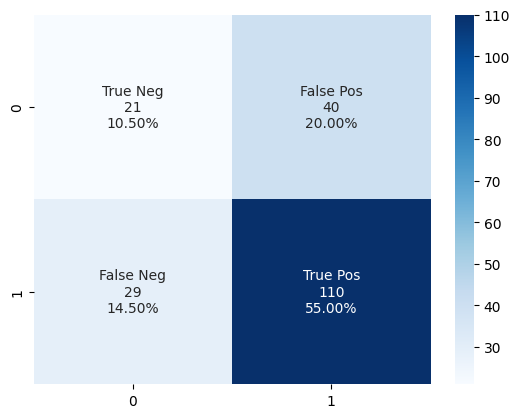

In [21]:
group_names = ["True Neg", "False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, fmt="", cmap='Blues', annot=labels)

In [23]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_labels,  y_pred_raw)
auc = metrics.roc_auc_score(test_labels, y_pred_raw)

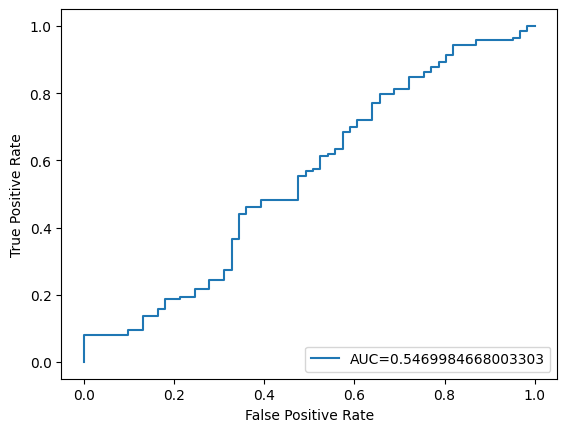

In [24]:
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()